In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import assignment3_functions as library
import pandas as pd
from sklearn import (svm, ensemble, tree,
                     linear_model, neighbors, naive_bayes, dummy)
pd.options.display.max_columns = 999
import warnings 
warnings.simplefilter('ignore')

#### Explore Data

#### First, I explored the donorschoose data, which contains information about projects and when they were funded. In this assignment, we assumed that all the projects were funded eventually. 

In [3]:
donors_df = library.file_to_dataframe("projects_2012_2013.csv")

In [4]:
donors_df.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,school_county,school_charter,school_magnet,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,Cook,f,f,Mrs.,Mathematics,Math & Science,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,f,4/14/13,5/2/13
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,Ventura,f,f,Mrs.,Civics & Government,History & Civics,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,t,4/7/12,4/18/12
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,Los Angeles,f,f,Ms.,Literacy,Literacy & Language,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,f,1/30/12,4/15/12
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,Kings (Brooklyn),f,t,Ms.,Literacy,Literacy & Language,NaN,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,f,10/11/12,12/5/12
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,Suffolk,f,f,Mrs.,Literacy,Literacy & Language,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,f,1/8/13,3/25/13


#### The outcome variable we are interested in predicting is how likely it is that a project would be funded in 60 days. I created a binary outcome variable below, called '60_days_fullyfunded' for this purpose

In [5]:
donors_df['date_posted'] = pd.to_datetime(donors_df['date_posted'], format='%m/%d/%y')
donors_df['datefullyfunded'] = pd.to_datetime(donors_df['datefullyfunded'], format='%m/%d/%y')
donors_df['60_days_fullyfunded'] = (donors_df['datefullyfunded'] - donors_df['date_posted'] <= pd.to_timedelta(60, unit='days')).astype('int')
donors_df.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,school_county,school_charter,school_magnet,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded,60_days_fullyfunded
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,Cook,f,f,Mrs.,Mathematics,Math & Science,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,f,2013-04-14,2013-05-02,1
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,Ventura,f,f,Mrs.,Civics & Government,History & Civics,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,t,2012-04-07,2012-04-18,1
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,Los Angeles,f,f,Ms.,Literacy,Literacy & Language,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,f,2012-01-30,2012-04-15,0
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,Kings (Brooklyn),f,t,Ms.,Literacy,Literacy & Language,NaN,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,f,2012-10-11,2012-12-05,1
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,Suffolk,f,f,Mrs.,Literacy,Literacy & Language,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,f,2013-01-08,2013-03-25,0


#### Next, I pre-processed columns to make sure that they could be put into our machine learning models. I changed columns that had 't', 'f' to binary columns, and dropped whichever columns I felt would not be helpful for prediction. 

In [6]:
cols_list = ['eligible_double_your_impact_match', 'school_magnet', 'school_charter']

In [7]:
library.cols_to_dummy(donors_df, cols_list, 't')

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,school_county,school_charter,school_magnet,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded,60_days_fullyfunded
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,Cook,0,0,Mrs.,Mathematics,Math & Science,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,0,2013-04-14,2013-05-02,1
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,Ventura,0,0,Mrs.,Civics & Government,History & Civics,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,1,2012-04-07,2012-04-18,1
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,Los Angeles,0,0,Ms.,Literacy,Literacy & Language,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,0,2012-01-30,2012-04-15,0
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,Kings (Brooklyn),0,1,Ms.,Literacy,Literacy & Language,NaN,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,0,2012-10-11,2012-12-05,1
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,Suffolk,0,0,Mrs.,Literacy,Literacy & Language,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,0,2013-01-08,2013-03-25,0
5,00049ec8ca1f2d08cb13cab31b0b85ec,7149611553c700de9a6099f8a9ce598b,462a5fd93cf9fb5d41eecfd2ea860b19,2.621150e+11,42.740157,-84.525821,Lansing,MI,urban,Lansing School District,Ingham,0,0,Mrs.,Literacy,Literacy & Language,NaN,NaN,Other,highest poverty,Grades 3-5,475.85,15.0,0,2012-11-30,2013-02-26,0
6,0004d2fdbb571237fa53a97e7691440b,926671e209fb977bd5123145c1848ad1,1a994778027ab086dc58ec3b47f74ff0,4.047200e+10,33.059361,-112.037727,Maricopa,AZ,rural,Maricopa Unif Sch District 20,Pinal,0,0,Ms.,Literacy,Literacy & Language,NaN,NaN,Supplies,high poverty,Grades 3-5,390.65,37.0,0,2013-03-26,2013-04-17,1
7,0004ee26667e751dd51384eb9f30c72e,abe4dabb7864f4c548d230cf9070e03f,8409f70bcd81bc06e4b9efca68eed8f6,6.280501e+10,37.761958,-122.193209,Oakland,CA,urban,Oakland Unified School Dist,Alameda,0,0,Mr.,Mathematics,Math & Science,NaN,NaN,Books,highest poverty,Grades 9-12,3877.20,30.0,0,2013-02-28,2013-03-10,1
8,0006a31d45f8d52d217e7c5b55c11f37,3b5fada1ad0e339acc669829071320c4,c6a033f9349ea70659c1891b119680ed,2.307320e+11,44.096641,-70.191734,Lewiston,ME,urban,Lewiston Public Schools,Androscoggin,0,0,Mrs.,Other,Applied Learning,NaN,NaN,Technology,high poverty,Grades 3-5,838.75,25.0,0,2013-08-21,2013-09-13,1
9,0008ac907bf237a15a959244205d3ee5,92527a5ac5fe946ed1961fb2e1de8cc5,23e34f5d2e2940684269cffe35741598,6.271800e+10,34.381832,-118.531837,Newhall,CA,suburban,Newhall School District,Los Angeles,0,0,Ms.,Mathematics,Math & Science,Literacy,Literacy & Language,Technology,highest poverty,Grades PreK-2,1477.44,24.0,0,2012-10-03,2012-11-03,1


In [8]:
#drop ID columns

In [9]:
donors_df.drop(labels = ['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid'], axis=1, inplace=True)

In [10]:
#drop geographical columns that are redundant

In [11]:
donors_df.drop(labels = ['school_city', 'school_state', 'school_metro', 'school_latitude', 'school_longitude', 'school_county'], axis=1, inplace=True)
donors_df

,school_district,school_charter,school_magnet,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded,60_days_fullyfunded
0,Pershing Elem Network,0,0,Mrs.,Mathematics,Math & Science,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,0,2013-04-14,2013-05-02,1
1,Ventura Unif School District,0,0,Mrs.,Civics & Government,History & Civics,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,1,2012-04-07,2012-04-18,1
2,Los Angeles Unif Sch Dist,0,0,Ms.,Literacy,Literacy & Language,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,0,2012-01-30,2012-04-15,0
3,New York City Dept Of Ed,0,1,Ms.,Literacy,Literacy & Language,NaN,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,0,2012-10-11,2012-12-05,1
4,Central Islip Union Free SD,0,0,Mrs.,Literacy,Literacy & Language,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,0,2013-01-08,2013-03-25,0
5,Lansing School District,0,0,Mrs.,Literacy,Literacy & Language,NaN,NaN,Other,highest poverty,Grades 3-5,475.85,15.0,0,2012-11-30,2013-02-26,0
6,Maricopa Unif Sch District 20,0,0,Ms.,Literacy,Literacy & Language,NaN,NaN,Supplies,high poverty,Grades 3-5,390.65,37.0,0,2013-03-26,2013-04-17,1
7,Oakland Unified School Dist,0,0,Mr.,Mathematics,Math & Science,NaN,NaN,Books,highest poverty,Grades 9-12,3877.20,30.0,0,2013-02-28,2013-03-10,1
8,Lewiston Public Schools,0,0,Mrs.,Other,Applied Learning,NaN,NaN,Technology,high poverty,Grades 3-5,838.75,25.0,0,2013-08-21,2013-09-13,1
9,Newhall School District,0,0,Ms.,Mathematics,Math & Science,Literacy,Literacy & Language,Technology,highest poverty,Grades PreK-2,1477.44,24.0,0,2012-10-03,2012-11-03,1


#### Next, I looked at correlations to see which features are highly correlated, intending to drop columns that were highly correlated. I didn't identify any columns to drop through my initial inspection of the correlation matrix below

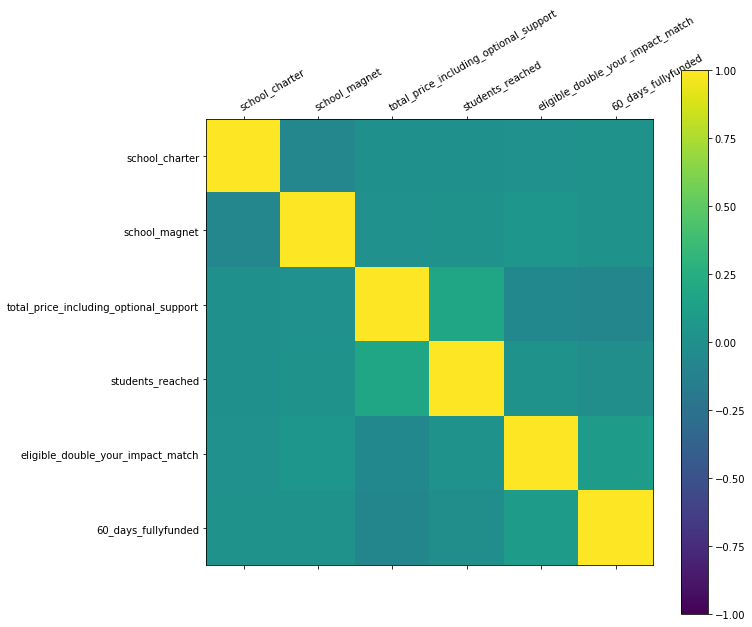

In [12]:
correlations = library.correlations(donors_df)
correlation_matrix = library.correlation_matrix(correlations)

#### Finally, I looked at NA columns to see if there were any NA columns to fill after splitting the data, and any columns with too many NAs that I should just drop. I decided to drop the secondary_focus_area columns because of this. 

In [13]:
library.na_summary(donors_df)

school_district                             172
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_subject                        15
primary_focus_area                           15
secondary_focus_subject                   40556
secondary_focus_area                      40556
resource_type                                17
poverty_level                                 0
grade_level                                   3
total_price_including_optional_support        0
students_reached                             59
eligible_double_your_impact_match             0
date_posted                                   0
datefullyfunded                               0
60_days_fullyfunded                           0
dtype: int64

In [14]:
donors_df.drop(labels = ['secondary_focus_subject', 'secondary_focus_area', 'datefullyfunded'], axis=1, inplace=True)

#### Next, I made binary columns for categorical columns

In [15]:
vars_to_categorize = ['teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'school_district']
donors_df = library.categorize(donors_df, vars_to_categorize)
donors_df.head()

,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,60_days_fullyfunded,teacher_prefix_Dr.,teacher_prefix_Mr.,teacher_prefix_Mrs.,teacher_prefix_Ms.,primary_focus_subject_Applied Sciences,primary_focus_subject_Character Education,primary_focus_subject_Civics & Government,primary_focus_subject_College & Career Prep,primary_focus_subject_Community Service,primary_focus_subject_ESL,primary_focus_subject_Early Development,primary_focus_subject_Economics,primary_focus_subject_Environmental Science,primary_focus_subject_Extracurricular,primary_focus_subject_Foreign Languages,primary_focus_subject_Gym & Fitness,primary_focus_subject_Health & Life Science,primary_focus_subject_Health & Wellness,primary_focus_subject_History & Geography,primary_focus_subject_Literacy,primary_focus_subject_Literature & Writing,primary_focus_subject_Mathematics,primary_focus_subject_Music,primary_focus_subject_Nutrition,primary_focus_subject_Other,primary_focus_subject_Parent Involvement,primary_focus_subject_Performing Arts,primary_focus_subject_Social Sciences,primary_focus_subject_Special Needs,primary_focus_subject_Sports,primary_focus_subject_Visual Arts,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,school_district_Abbeville Co School District,school_district_Abc Unified School District,school_district_Aberdeen School District 5,school_district_Abilene Ind School District,school_district_Abingdon Cmty Unit SD 217,school_district_Abington Public Sch District,school_district_Abington School District,school_district_Absecon City Elem Sch District,school_district_Academy School District 20,school_district_Acadia Parish School District,school_district_Acalanes Union High Sch Dist,school_district_Accomack Co School District,school_district_Achievement School District,school_district_Acton Agua Dulce Unif Sch Dist,school_district_Acton Public School District,school_district_Ada School District 19,school_district_Adair Co School District,school_district_Adair School District I-2,school_district_Adams 12 Five Star Schools,school_district_Adams Co School District 14,school_district_Adams Co School District 50,school_district_Adams-cheshire Reg Sch Dist,school_district_Addison Cmty School District,school_district_Addison Elem School District 4,school_district_Addison Northeast Su 1,school_district_Adel-de Soto-minburn Cmty SD,school_district_Adelanto School District,school_district_Adna School District 226,school_district_Adrian Public School District,school_district_Adrian School District R3,school_district_Advantage Academy Admin Office,school_district_Affton School District 101,school_district_Agawam School District,school_district_Agua Fria Union High SD 216,school_district_Aiken Co School District,school_district_Airport Cmty School District,school_district_Aitkin Ind School District 1,school_district_Akron Public Schools,school_district_Alachua Co School District,school_district_Alamance-burlington Sch Dist,school_district_Alameda Co Office of Education,school_district_Alameda Unified School Dist,school_district_Alamo Heights Ind School Dist,school_district_Alamogordo School District 1,school_district_Alamosa Sch Dist Re-11J,school_district_Alaska Gateway School District,school_district_Albany City School District,school_district_Albany Co School District 1,school_district_Albany Unified School District,school_district_Albemarle Co School Dis

#### Next, I discretized numeric variables and categorized them

In [16]:
vars_to_discretize = ['total_price_including_optional_support', 'students_reached']
donors_df = library.discretize(donors_df, vars_to_discretize)
donors_df.drop(labels = vars_to_discretize, axis=1, inplace=True)
vars_to_categorize = ['total_price_including_optional_support_discrete', 'students_reached_discrete']
donors_df = library.categorize(donors_df, vars_to_categorize)

In [17]:
donors_df.head()

,school_charter,school_magnet,eligible_double_your_impact_match,date_posted,60_days_fullyfunded,teacher_prefix_Dr.,teacher_prefix_Mr.,teacher_prefix_Mrs.,teacher_prefix_Ms.,primary_focus_subject_Applied Sciences,primary_focus_subject_Character Education,primary_focus_subject_Civics & Government,primary_focus_subject_College & Career Prep,primary_focus_subject_Community Service,primary_focus_subject_ESL,primary_focus_subject_Early Development,primary_focus_subject_Economics,primary_focus_subject_Environmental Science,primary_focus_subject_Extracurricular,primary_focus_subject_Foreign Languages,primary_focus_subject_Gym & Fitness,primary_focus_subject_Health & Life Science,primary_focus_subject_Health & Wellness,primary_focus_subject_History & Geography,primary_focus_subject_Literacy,primary_focus_subject_Literature & Writing,primary_focus_subject_Mathematics,primary_focus_subject_Music,primary_focus_subject_Nutrition,primary_focus_subject_Other,primary_focus_subject_Parent Involvement,primary_focus_subject_Performing Arts,primary_focus_subject_Social Sciences,primary_focus_subject_Special Needs,primary_focus_subject_Sports,primary_focus_subject_Visual Arts,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,school_district_Abbeville Co School District,school_district_Abc Unified School District,school_district_Aberdeen School District 5,school_district_Abilene Ind School District,school_district_Abingdon Cmty Unit SD 217,school_district_Abington Public Sch District,school_district_Abington School District,school_district_Absecon City Elem Sch District,school_district_Academy School District 20,school_district_Acadia Parish School District,school_district_Acalanes Union High Sch Dist,school_district_Accomack Co School District,school_district_Achievement School District,school_district_Acton Agua Dulce Unif Sch Dist,school_district_Acton Public School District,school_district_Ada School District 19,school_district_Adair Co School District,school_district_Adair School District I-2,school_district_Adams 12 Five Star Schools,school_district_Adams Co School District 14,school_district_Adams Co School District 50,school_district_Adams-cheshire Reg Sch Dist,school_district_Addison Cmty School District,school_district_Addison Elem School District 4,school_district_Addison Northeast Su 1,school_district_Adel-de Soto-minburn Cmty SD,school_district_Adelanto School District,school_district_Adna School District 226,school_district_Adrian Public School District,school_district_Adrian School District R3,school_district_Advantage Academy Admin Office,school_district_Affton School District 101,school_district_Agawam School District,school_district_Agua Fria Union High SD 216,school_district_Aiken Co School District,school_district_Airport Cmty School District,school_district_Aitkin Ind School District 1,school_district_Akron Public Schools,school_district_Alachua Co School District,school_district_Alamance-burlington Sch Dist,school_district_Alameda Co Office of Education,school_district_Alameda Unified School Dist,school_district_Alamo Heights Ind School Dist,school_district_Alamogordo School District 1,school_district_Alamosa Sch Dist Re-11J,school_district_Alaska Gateway School District,school_district_Albany City School District,school_district_Albany Co School District 1,school_district_Albany Unified School District,school_district_Albemarle Co School District,school_district_Albert Lea Area Schools,school_dis

## Building Models/Evaluation on regular train, test splits

#### Finally,  I selected features for running the machine learning models, and split the data into train and test

In [18]:
selected_features = [col for col in donors_df if col not in ['date_posted', 'datefullyfunded', '60_days_fullyfunded']]
x_train, x_test, y_train, y_test = library.split_data(donors_df, selected_features, ['60_days_fullyfunded'], 0.2)

#### Here I demonstrate how my pipeline functions could be used to run machine learning models. The analysis below is based on a regular train, test split and not a temporal split. I will later show the results for temporal split/analysis that follows.

In [19]:
TEST_GRID = {
            'RF': {'n_estimators': 1, 'max_depth': 1, 'max_features': 'sqrt','min_samples_split': 10},
            'LR': {'penalty': 'l1', 'C': 0.01},
            'AB': {'algorithm': 'SAMME', 'n_estimators': 1},
            'DT': {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt','min_samples_split': 10},
            'SVM': {'tol': 1e-5, 'random_state': 0},
            'KNN': {'n_neighbors': 10,'weights': 'uniform','algorithm': 'auto'}
            }

#### In the interest of runtime, I build classifiers and show the evaluation tables for RandomForest, Boosting, Logistic Regression, and Decision Trees. SVM and KNN are run later, in the temporal splits section. The table below allows us to see, for one parameter specification for each model, how the precision, recall, accuracy, and AUC change as we change the threshold k.

In [20]:
simple_model_run = ['RF', 'AB', 'LR', 'DT']
fitted_models = library.build_classifier(x_train, y_train, simple_model_run, TEST_GRID)
eval_df = library.create_eval_table(x_test, y_test, fitted_models, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], simple_model_run)
eval_df

running model,
RF
running model,
AB
running model,
LR
running model,
DT
running through...
RF
running through...
AB
running through...
LR
running through...
DT


,model,k,precision,accuracy,recall,auc
0,RF,0.1,0.625000,0.288686,0.000843,0.522171
1,RF,0.2,0.673469,0.289126,0.001855,0.522171
2,RF,0.3,0.729730,0.289806,0.003036,0.522171
3,RF,0.4,0.727273,0.290246,0.004048,0.522171
4,RF,0.5,0.733871,0.290767,0.005116,0.522171
5,RF,0.6,0.711409,0.290967,0.005960,0.522171
6,RF,0.7,0.701149,0.291247,0.006859,0.522171
7,AB,0.1,0.625000,0.288686,0.000843,0.546719
8,AB,0.2,0.673469,0.289126,0.001855,0.546719
9,AB,0.3,0.729730,0.289806,0.003036,0.546719


## Temporal Validation Analysis

#### Now, I set up the parameters for doing temporal validation on the dataset. In this part of the analysis, I compare different parameters and models over 3 different train, test splits. 

#### I start by running all the models on a smaller timeframe, because of issues with runtime when doing this on the larger timeframe. The data is split in the following manner: 

In [21]:
start_time = '2012-01-01'
end_time = '2012-04-30'
temp_split_small = library.temporal_validate(start_time, end_time, [1])
temp_split_small

[[datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2012, 1, 31, 0, 0),
  datetime.datetime(2012, 2, 1, 0, 0),
  datetime.datetime(2012, 2, 29, 0, 0),
  1],
 [datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2012, 2, 29, 0, 0),
  datetime.datetime(2012, 3, 1, 0, 0),
  datetime.datetime(2012, 3, 31, 0, 0),
  1],
 [datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2012, 3, 31, 0, 0),
  datetime.datetime(2012, 4, 1, 0, 0),
  datetime.datetime(2012, 4, 30, 0, 0),
  1]]

In [22]:
models_to_run = ['RF', 'AB', 'LR', 'SVM', 'DT', 'KNN']

classifiers = {'RF': ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1),
    'LR': linear_model.LogisticRegression(penalty='l1', C=1e5),
    'SVM': svm.LinearSVC(tol= 1e-5, random_state=0),
    'AB': ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
    'DT': tree.DecisionTreeClassifier(),
    'KNN': neighbors.KNeighborsClassifier(n_neighbors=3),
        }

parameters = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5, 20, 100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.001,0.1,1,10]},
    'AB': { 'algorithm': ['SAMME'], 'n_estimators': [1]},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,10,20,100],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.01]},
    'KNN' :{'n_neighbors': [25],'weights': ['uniform','distance'],'algorithm': ['ball_tree']},
           }

In [23]:
results_df, params = library.create_temporal_eval_table(models_to_run, classifiers, parameters, donors_df, '60_days_fullyfunded', temp_split_small, 'date_posted', "final_tables.csv")

Running through model RF...
Running through model AB...
Running through model LR...
Running through model SVM...
Running through model DT...
Running through model KNN...
Running through model RF...
Running through model AB...
Running through model LR...
Running through model SVM...
Running through model DT...
Running through model KNN...
Running through model RF...
Running through model AB...
Running through model LR...
Running through model SVM...
Running through model DT...
Running through model KNN...


In [24]:
results_without_baseline = results_df[results_df['model_type'] != 'baseline']
best_model = results_without_baseline.loc[results_without_baseline['auc-roc'].idxmax()]
best_model

train_start                                  2012-01-01 00:00:00
train_end                                    2012-03-31 00:00:00
test_start                                   2012-04-01 00:00:00
test_end                                     2012-04-30 00:00:00
model_type                                                    RF
classifier     (DecisionTreeClassifier(class_weight=None, cri...
train_size                                                 18417
test_size                                                   2763
auc-roc                                                 0.521825
p_at_1                                                  0.925926
a_at_1                                                  0.281578
r_at_1                                                 0.0124502
p_at_2                                                  0.927273
a_at_2                                                  0.290264
r_at_2                                                 0.0253984
p_at_5                   

In [25]:
params[133]

{'max_depth': 20,
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 100,
 'n_jobs': -1}

#### Now running with 6 month splits

In [26]:
start_time_6mo = '2012-01-01'
end_time_6mo = '2013-12-31'
prediction_windows = 6
temp_split_6mo = library.temporal_validate(start_time_6mo, end_time_6mo, [6])

In [27]:
temp_split_6mo

[[datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2012, 6, 30, 0, 0),
  datetime.datetime(2012, 7, 1, 0, 0),
  datetime.datetime(2012, 12, 31, 0, 0),
  6],
 [datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2012, 12, 31, 0, 0),
  datetime.datetime(2013, 1, 1, 0, 0),
  datetime.datetime(2013, 6, 30, 0, 0),
  6],
 [datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2013, 6, 30, 0, 0),
  datetime.datetime(2013, 7, 1, 0, 0),
  datetime.datetime(2013, 12, 31, 0, 0),
  6]]

#### Now running only DecisionTrees, RandomForests, Logistic Regression, and Boosting in the interest of runtime

In [28]:
models_to_run_6mo = ['RF','LR', 'DT', 'AB']

In [29]:
results_df_6mo, params_6mo = library.create_temporal_eval_table(models_to_run_6mo, classifiers, parameters, donors_df, '60_days_fullyfunded', temp_split_6mo, 'date_posted', "final_tables_6mo_2.csv")

Running through model RF...
Running through model LR...
Running through model DT...
Running through model AB...
Running through model RF...
Running through model LR...
Running through model DT...
Running through model AB...
Running through model RF...
Running through model LR...
Running through model DT...
Running through model AB...


In [30]:
results_df_6mo

,train_start,train_end,test_start,test_end,model_type,classifier,train_size,test_size,auc-roc,p_at_1,a_at_1,r_at_1,p_at_2,a_at_2,r_at_2,p_at_5,a_at_5,r_at_5,p_at_10,a_at_10,r_at_10,p_at_20,a_at_20,r_at_20,p_at_30,a_at_30,r_at_30,p_at_50,a_at_50,r_at_50
0,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",26386,32838,0.500348,0.960366,0.266125,0.0129093,0.940549,0.27453,0.0252858,0.94089,0.300993,0.0632761,0.916235,0.340155,0.123274,0.893559,0.414337,0.240482,0.860522,0.473232,0.347404,0.809854,0.566782,0.544937
1,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",26386,32838,0.498124,0.966463,0.266246,0.0129913,0.95122,0.274956,0.0255727,0.942108,0.301115,0.0633581,0.923241,0.341556,0.124216,0.897822,0.416042,0.241629,0.874835,0.48182,0.353182,0.832998,0.589926,0.56051
2,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",26386,32838,0.493581,0.948171,0.265881,0.0127454,0.974085,0.275869,0.0261875,0.94028,0.300932,0.0632351,0.922936,0.341495,0.124175,0.891884,0.413667,0.240031,0.880317,0.485109,0.355395,0.813752,0.57068,0.54756
3,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",26386,32838,0.501084,0.969512,0.266307,0.0130323,0.967988,0.275626,0.0260235,0.947593,0.301663,0.0637269,0.92781,0.342469,0.124831,0.903457,0.418296,0.243146,0.87788,0.483647,0.354412,0.835495,0.592423,0.56219
4,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",26386,32838,0.495544,0.762195,0.262166,0.0102455,0.769817,0.267708,0.0206959,0.872639,0.294171,0.0586861,0.834602,0.323832,0.11229,0.917314,0.423838,0.246875,0.944879,0.523844,0.38146,0.966929,0.723857,0.650629
5,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",26386,32838,0.508254,0.878049,0.26448,0.0118028,0.900915,0.272946,0.0242203,0.906764,0.297582,0.0609811,0.898873,0.336683,0.120938,0.875133,0.406968,0.235523,0.855243,0.470065,0.345273,0.818807,0.575735,0.550961
6,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",26386,32838,0.500956,0.719512,0.261313,0.00967173,0.800305,0.268926,0.0215155,0.87142,0.29405,0.0586042,0.861712,0.329253,0.115938,0.906502,0.419514,0.243965,0.937671,0.51952,0.37855,0.798282,0.55521,0.53715
7,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",26386,32838,0.504074,0.926829,0.265455,0.0124585,0.916159,0.273555,0.0246301,0.89092,0.295999,0.0599156,0.887298,0.334369,0.11938,0.860515,0.401121,0.231589,0.834129,0.457397,0.336748,0.805652,0.56258,0.542109
8,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",26386,32838,0.500361,0.911585,0.26515,0.0122536,0.914634,0.273494,0.0245892,0.907374,0.297643,0.0610221,0.890344,0.334978,0.11979,0.874067,0.406541,0.235236,0.850675,0.467324,0.343429,0.817955,0.574883,0.550387
9,2012-01-01,2012-06-30,2012-07-01,2012-12-31,RF,"(DecisionTreeClassifier(class_weight=None, cri...",26386,32838,0.504838,0.963415,0.266186,0.0129503,0.957317,0.275199,0.0257367,0.937233,0.300627,0.0630302,0.928419,0.342591,0.124913,0.901173,0.417382,0.242531,0.877982,0.483708,0.354453,0.834338,0.591266,0.561411


In [31]:
results_without_baseline_6mo = results_df_6mo[results_df_6mo['model_type'] != 'baseline']
best_model_6mo = results_without_baseline_6mo.loc[results_without_baseline_6mo['auc-roc'].idxmax()]
best_model_6mo

train_start                                  2012-01-01 00:00:00
train_end                                    2012-12-31 00:00:00
test_start                                   2013-01-01 00:00:00
test_end                                     2013-06-30 00:00:00
model_type                                                    RF
classifier     (DecisionTreeClassifier(class_weight=None, cri...
train_size                                                 59224
test_size                                                  21585
auc-roc                                                  0.50842
p_at_1                                                  0.897674
a_at_1                                                  0.322863
r_at_1                                                  0.013052
p_at_2                                                   0.87239
a_at_2                                                  0.329812
r_at_2                                                 0.0254277
p_at_5                   

In [32]:
params_6mo[75]

{'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 10,
 'n_jobs': -1}

In [33]:
#now training the best model, and showing precision/recall curve, feature importances, etc

In [34]:
x_train_6mo, x_test_6mo, y_train_6mo, y_test_6mo = library.temporal_split(donors_df, 'date_posted', '60_days_fullyfunded', best_model_6mo['train_start'], best_model_6mo['train_end'], best_model_6mo['test_start'], best_model_6mo['test_end'])

In [35]:
x_train_6mo = library.process(x_train_6mo, 'students_reached')
x_test_6mo = library.process(x_test_6mo, 'students_reached')
rf = ensemble.RandomForestClassifier(max_depth=100, max_features='sqrt', min_samples_split=10, n_estimators=10, n_jobs=-1)
y_pred_probs_6mo = rf.fit(x_train, y_train).predict_proba(x_test_6mo)[:,1]

<Figure size 720x720 with 0 Axes>

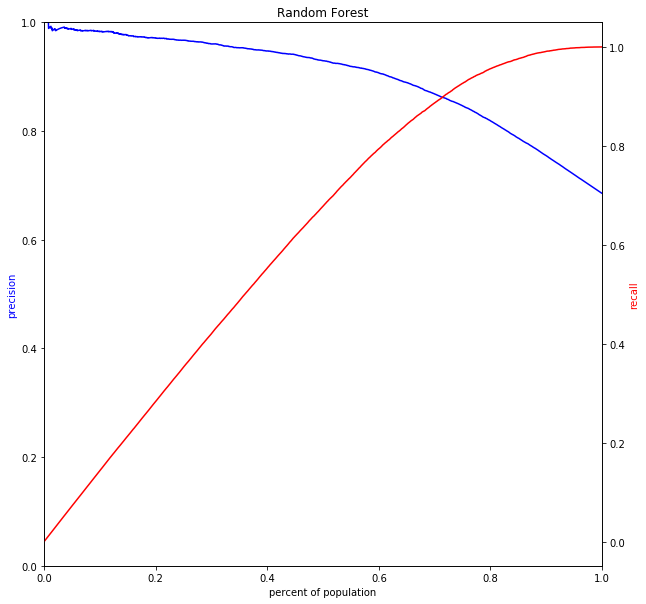

In [36]:
library.plot_precision_recall_n(y_test_6mo, y_pred_probs_6mo, "Random Forest")

#### Best model, if you were looking for precision at 5%

In [37]:
best_model_5_6mo = results_without_baseline_6mo.loc[results_without_baseline['p_at_5'].astype('float').idxmax()]
best_model_5_6mo

train_start                                  2012-01-01 00:00:00
train_end                                    2012-06-30 00:00:00
test_start                                   2012-07-01 00:00:00
test_end                                     2012-12-31 00:00:00
model_type                                                    RF
classifier     (DecisionTreeClassifier(class_weight=None, cri...
train_size                                                 26386
test_size                                                  32838
auc-roc                                                 0.494957
p_at_1                                                         1
a_at_1                                                  0.266916
r_at_1                                                 0.0134421
p_at_2                                                         1
a_at_2                                                  0.276905
r_at_2                                                 0.0268841
p_at_5                   

#### Finding feature importances

#### Bar graph comparing models across various metrics